In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

# Step 1: Download Data
interval = "1d"
data = yf.download("^NSEI", interval=interval)
if data.empty:
    raise ValueError("No data retrieved. Check the ticker or internet connection.")

# Reset index and prepare columns
data.reset_index(inplace=True)
data.columns = [i[0] for i in data.columns]

# Add a Moving Average (Optional Enhancement)
data["MA20"] = data["Close"].rolling(window=20).mean()

# Drop rows with NaN values (caused by rolling window)
data.dropna(inplace=True)

# Step 2: Scale Data (Close Prices)
scaler = MinMaxScaler()
data["Close_Scaled"] = scaler.fit_transform(data["Close"].values.reshape(-1, 1))

# Step 3: Sliding Window Function
def window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Prepare Data for Model
window_size = 50
X, y = window(data["Close_Scaled"].values, window_size)

# Split Data into Train and Test
split = int(len(X) * 0.8)  # 80% training data
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape Data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 4: Define the LSTM Model for GridSearchCV
def build_lstm(units=50, dropout_rate=0.2, optimizer="adam"):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Step 5: Wrap the Model with scikeras' KerasRegressor
model = KerasRegressor(model=build_lstm, verbose=1)

# Define the Parameter Grid
param_grid = {
    "model__units": [50, 100],         # Number of LSTM units
    "model__dropout_rate": [0.2, 0.3], # Dropout rates
    "batch_size": [32, 64],             # Batch sizes
    "epochs": [20, 50],                     # Number of epochs
    "model__optimizer": ["adam"] # Optimizers
}

# Step 6: Run GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Print the Best Parameters and Score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

# Use the Best Model
best_model = grid_result.best_estimator_

# Predictions on the Test Set
predictions = best_model.predict(X_test)

# Reshape and Inverse Transform Predictions and Actuals
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(14, 7))
plt.plot(y_test, color="blue", label="Actual Prices")
plt.plot(predictions, color="red", label="Predicted Prices")
plt.title("Model Predictions vs Actual Prices (After Hyperparameter Tuning)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

# Step 7: Future Predictions (5 Steps Ahead)
future_pred = X_test[-1].copy()
future_preds = []

for i in range(5):
    next_pred = best_model.predict(future_pred.reshape(1, -1, 1))
    future_preds.append(next_pred[0])
    future_pred = np.append(future_pred[1:], next_pred)

# Inverse Transform Future Predictions
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Plot Future Predictions
plt.figure(figsize=(8, 5))
plt.plot(future_preds, marker="o", color="green", label="Future Predictions")
plt.title("5-Step Ahead Predictions")
plt.xlabel("Future Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
best_model.model_.save("best_lstm_model.keras")

In [ ]:
import pickle

In [ ]:
pickle.dump(scaler,open("scaler.pkl","wb"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

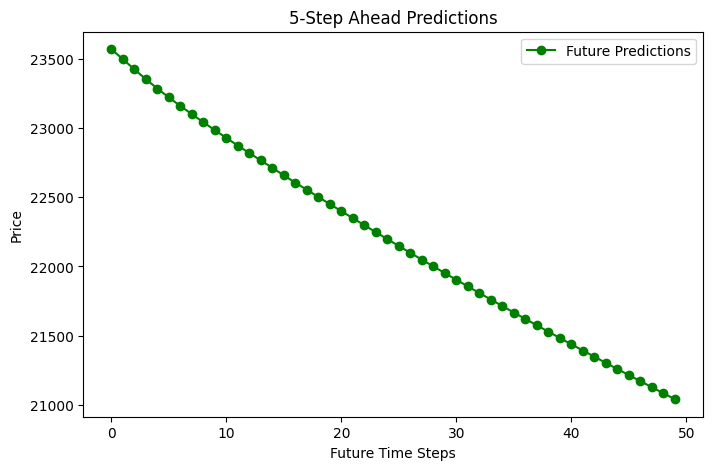

In [ ]:
future_pred = X_test[-1].copy()
future_preds = []
for i in range(50):
    next_pred = best_model.predict(future_pred.reshape(1, -1, 1))
    future_preds.append(next_pred[0])
    future_pred = np.append(future_pred[1:], next_pred)

# Inverse Transform Future Predictions
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Plot Future Predictions
plt.figure(figsize=(8, 5))
plt.plot(future_preds, marker="o", color="green", label="Future Predictions")
plt.title("5-Step Ahead Predictions")
plt.xlabel("Future Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()